# Sea-level budget

In [32]:
import matplotlib.pyplot as plt
import janitor  # noqa
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters.utils import ROOT_DIR

# Register dask progress bar
ProgressBar(minimum=5).register()

In [ ]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"

## Data Loading

Get target, WaterGAP and land mask:

In [3]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)

In [4]:
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
gap = inps.twsa_gap
grace = tgts.twsa_csr

In [5]:
# Load and combine all test and train predictions
pred_dir = ROOT_DIR / "models/predictions/global"

pred_zarrs = [
    pred_dir / "ensemble_alltrain_10folds_combined.zarr",
]
preds = xr.merge([xr.open_zarr(store) for store in pred_zarrs])

In [6]:
tws = xr.merge([gap, preds, recs, grace])
# Apply mask
tws = tws.where(mask == 1)
tws

<xarray.Dataset> Size: 29GB
Dimensions:                                    (time: 1480, lat: 360, lon: 720)
Coordinates:
  * lat                                        (lat) float64 3kB -89.75 ... 8...
  * lon                                        (lon) float32 3kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 12kB 190...
Data variables: (12/19)
    twsa_gap                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    humphrey_gsfc_deseason                     (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    ...                                         ...
    yin_csr_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_full                              (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_zerofill                          (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    twsa_csr                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
Attributes:
    long_name:      Terrestrial Water Storage Anomaly
    standard_name:  twsa
    units:          mm

In [7]:
vars_verbose = {
    "pred_ensemble_alltrain_gap_lnll_latest": "Ours, w/ WGHM",
    "pred_ensemble_alltrain_nogap_lnll_latest": "Ours, w/o WGHM",
    "twsa_gap": "WaterGAP (WGHM)",
    # "humphrey_gsfc_detrend": "Humphrey's GSFC REC (detrend)",
    "li_csr_full": "Li's CSR REC",
    "yin_csr_full": "Yin's CSR REC",
}
eval_names = list(vars_verbose.keys())

### Calculate the global TWSA mean

In [8]:
tws_mean = (
    tws[eval_names]
    # Only select the time where our prediction is available
    .sel(time=slice(preds.time[0], preds.time[-1]), drop=True)
    .dw.weight_lat()
    .mean(["lat", "lon"])
    # Calculate yearly averages
    .groupby("time.year")
    .mean()
    .compute()
)

[########################################] | 100% Completed | 53.72 s


Plot global trends:

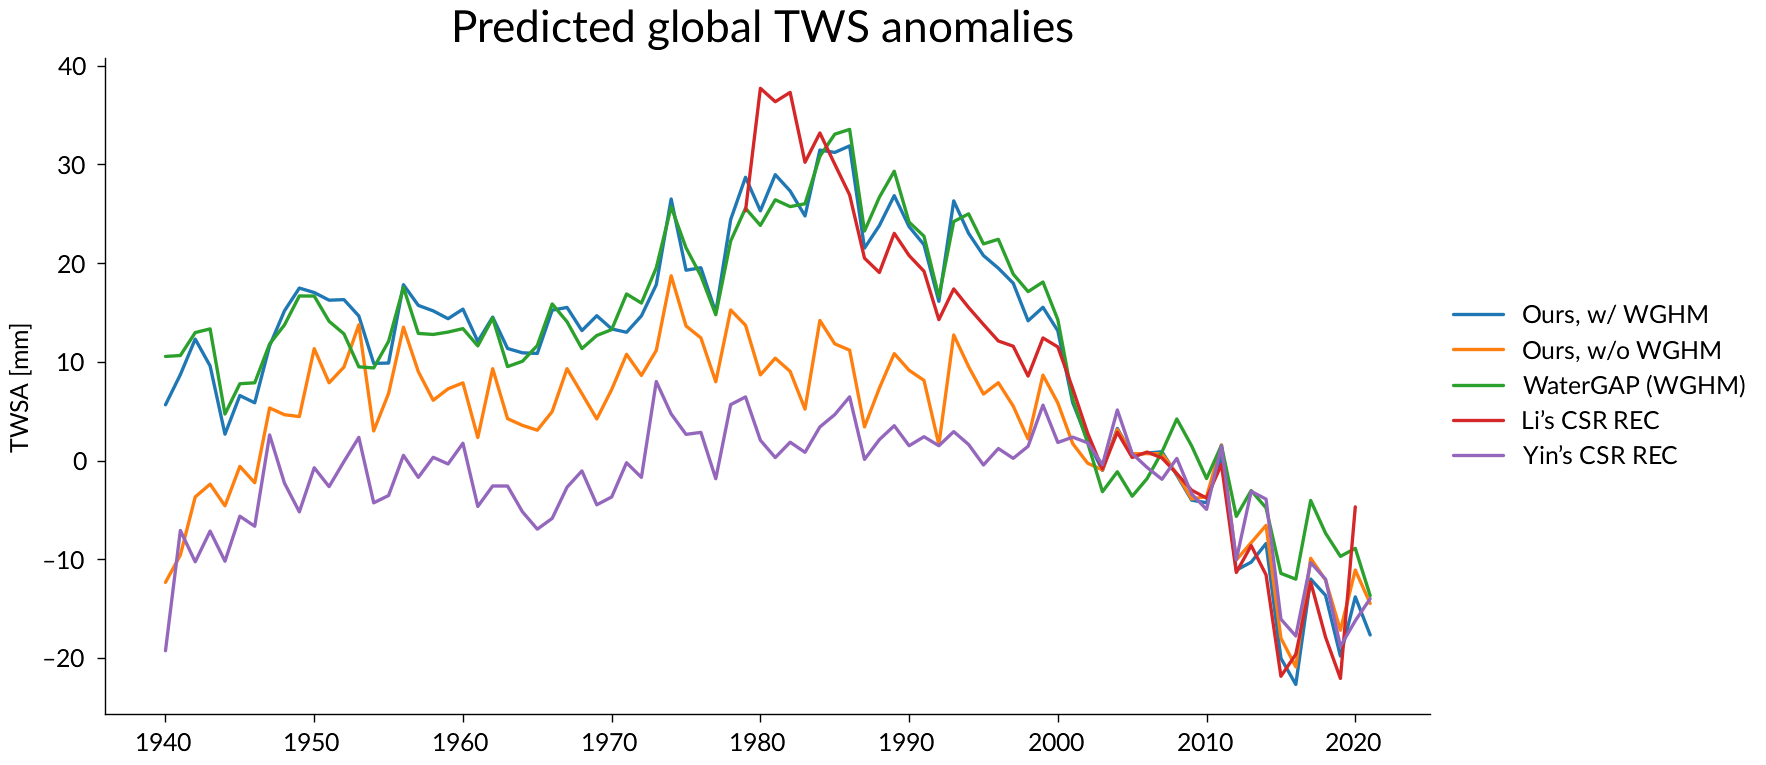

In [9]:
title_kwargs = dict(fontsize=16, weight="bold")

ax = tws_mean.to_pandas().rename(columns=vars_verbose).plot(figsize=(9, 4))
ax.set_title("Predicted global TWS anomalies", **title_kwargs)
ax.set_xlabel(None)
ax.set_ylabel("TWSA [mm]")
sns.move_legend(
    ax, loc="center left", bbox_to_anchor=(1, 0.5), title=None, frameon=False
)

### Load GMSL Components

In [10]:
df = pd.read_excel(
    ROOT_DIR / "data/raw/inputs/sea-level/frederikse/global_basin_timeseries.xlsx"
)
df = df.rename(columns={df.columns[0]: "year"}).set_index("year")
df.columns = df.columns.str.replace(r"[\[\]]", "", regex=True)
df = df.clean_names()

In [11]:
# But bounds into separate dataframes
df_mean = df[df.columns[df.columns.str.endswith("mean")]]
df_upper = df[df.columns[df.columns.str.endswith("upper")]]
df_lower = df[df.columns[df.columns.str.endswith("lower")]]

df_mean.columns = df_mean.columns.str.replace("_mean", "")
df_upper.columns = df_upper.columns.str.replace("_upper", "")
df_lower.columns = df_lower.columns.str.replace("_lower", "")

# Drop TWS subprocesses
# drop_subtws = ["natural_tws", "groundwater_depletion", "reservoir_impoundment"]
# df_mean = df_mean.drop(columns=drop_subtws)
# df_upper = df_upper.drop(columns=drop_subtws)
# df_lower = df_lower.drop(columns=drop_subtws)

### Bounds calc

Upper and lower bounds are 90 % confidence, which is equal to a Z-score of 1.645.


1. **Understand the Confidence Interval**:
   - The confidence interval is given as $(L, U)$, where $L$ is the lower bound and $U$ is the upper bound.
   - For a 90% confidence interval, the bounds represent the range within which the true mean is expected to fall 90% of the time.

2. **Calculate the Margin of Error**:
   - The margin of error (E) is half the width of the confidence interval.
   - $ E = \frac{U - L}{2} $

3. **Relate the Margin of Error to the Standard Error**:
   - The margin of error for a 90% confidence interval corresponds to the z-score for the 95th percentile, which is approximately 1.645.
   - Thus, the margin of error $E$ is related to the standard error (SE) by:
     $ E = z \cdot SE $
   - For a 90% confidence interval, $ z \approx 1.645 $.

4. **Calculate the Standard Error**:
   - From the margin of error and the z-score:
     $ SE = \frac{E}{z} = \frac{(U - L) / 2}{1.645} $

5. **Calculate the Variance**:
   - The standard error (SE) is the standard deviation of the predictions from the models divided by the square root of the number of models ($N$).
   - Rearrange this to solve for the variance ($\sigma^2$):
     $ \sigma^2 = (SE \cdot \sqrt{N})^2 $

In [12]:
Z_SCORE = 1.645

# Calculate the variances of each variable
errors = (df_upper - df_lower) / 2
std_errors = errors / Z_SCORE
variances = std_errors**2

# Calculate the variance of the sum of GMSL components
comps = [
    "steric",
    "greenland_ice_sheet",
    "antarctic_ice_sheet",
    "terrestrial_water_storage",
    "glaciers",
]
var_summed = variances[comps].sum(axis=1)
# Calculate the 90 % CI of the summed components
error_summed = Z_SCORE * np.sqrt(var_summed)
ubound_summed = df_mean.sum_of_contributors + error_summed
lbound_summed = df_mean.sum_of_contributors - error_summed

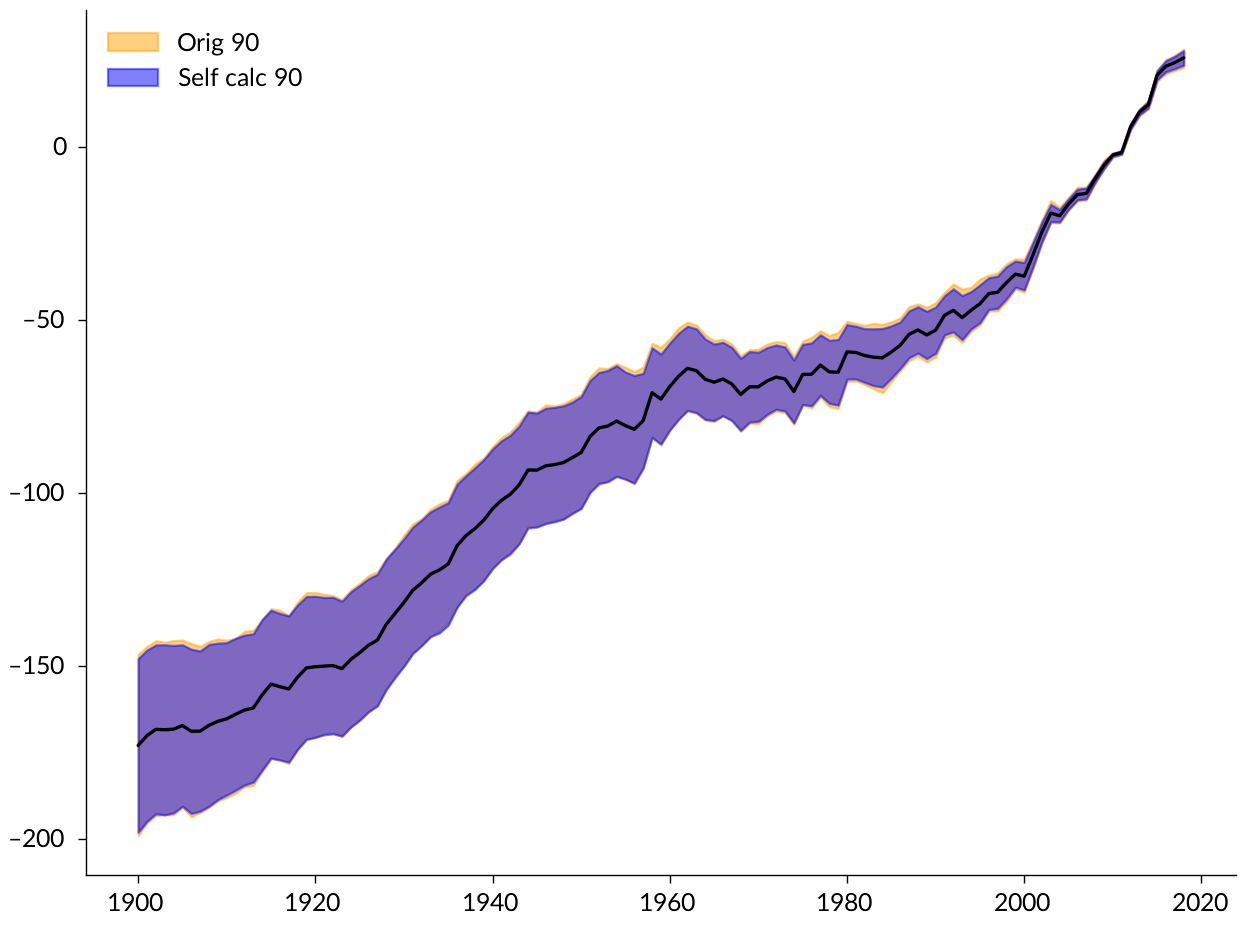

In [13]:
plt.plot(df_mean.sum_of_contributors, color="black")
plt.fill_between(
    df_mean.index,
    df_lower.sum_of_contributors,
    df_upper.sum_of_contributors,
    alpha=0.5,
    color="orange",
    label="Orig 90 % bounds",
)
plt.fill_between(
    df_mean.index,
    ubound_summed,
    lbound_summed,
    alpha=0.5,
    color="blue",
    label="Self calc 90 % bounds",
)
plt.legend();

The results are similar enough.

### Baseline adjustment

The negative globally averaged TWS on land is equal to the TWS contribution to the GMSL. To use our TWS predictions instead of Frederikse's, we have to make sure all Anomalies have the same baseline mean. We will use the GRACE baseline, contrary to Frederiks who uses 2002 to 2018 as baseline.

In [14]:
# Negate TWS and convert to dataframe
tws_preds = -tws_mean.to_pandas()

baseline = slice(2004, 2009)

# Predictions
preds_base = tws_preds.loc[baseline].mean()
tws_preds = tws_preds - preds_base

# GMSL mean
df_mean_base = df_mean.loc[baseline].mean()
df_mean = df_mean - df_mean_base

# GMSL bounds
df_upper = df_upper - df_mean_base
df_lower = df_lower - df_mean_base

In [15]:
# Add glaciers to Frederikse's TWS - the others already include them
tws_fred = df_mean.terrestrial_water_storage + df_mean.glaciers

In [16]:
assert np.isclose(tws_preds.loc[baseline].mean(), 0).all()
assert np.isclose(tws_fred.loc[baseline].mean(), 0).all()

In [17]:
# Add Frederikse's TWS prediction to dataframe
tws_preds["frederikse"] = tws_fred
vars_verbose["frederikse"] = "Frederikse's TWS REC"

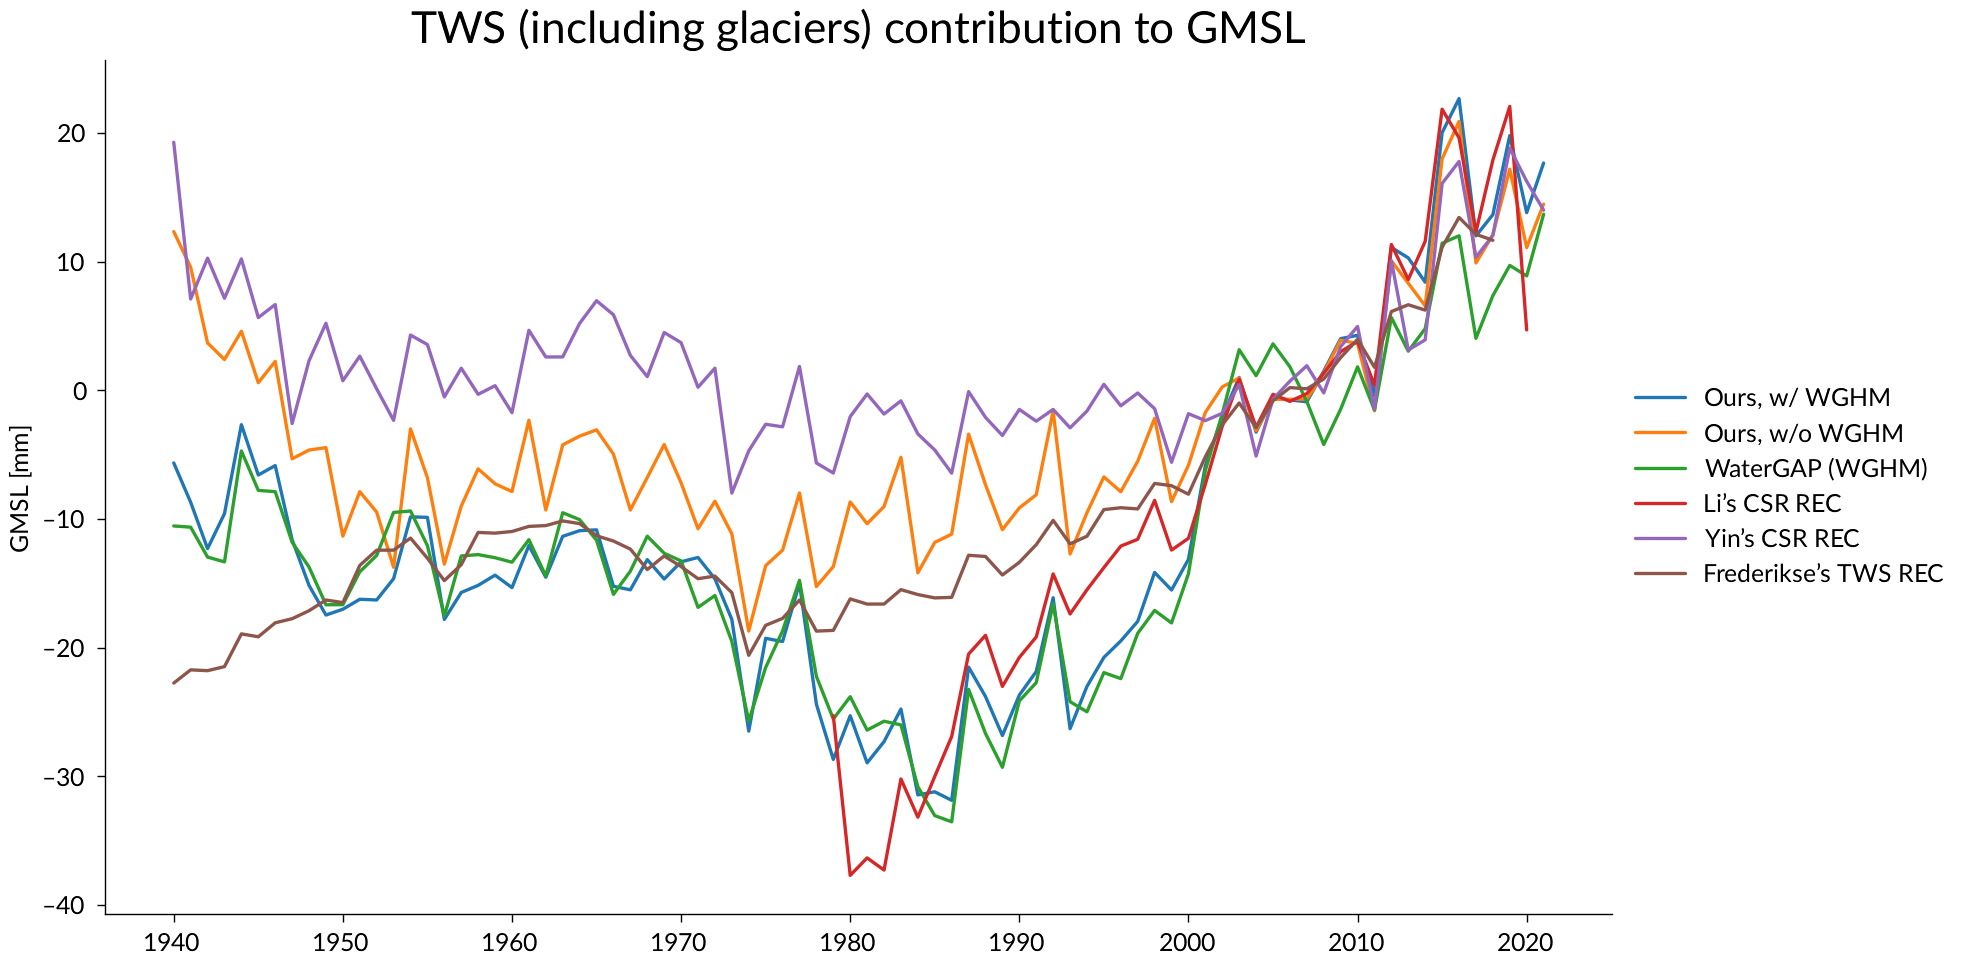

In [18]:
# Plot all TWS predictions
ax = tws_preds.rename(columns=vars_verbose).plot(figsize=(10, 5))
ax.set_title("TWS (including glaciers) contribution to GMSL", **title_kwargs)
ax.set_xlabel(None)
ax.set_ylabel("GMSL [mm]")
ax.legend(loc="lower center")
sns.move_legend(
    ax, loc="center left", bbox_to_anchor=(1, 0.5), title=None, frameon=False
)

Compare if a reconstructed product is indeed equal to the sum of Frederikse's TWS and glacier products:

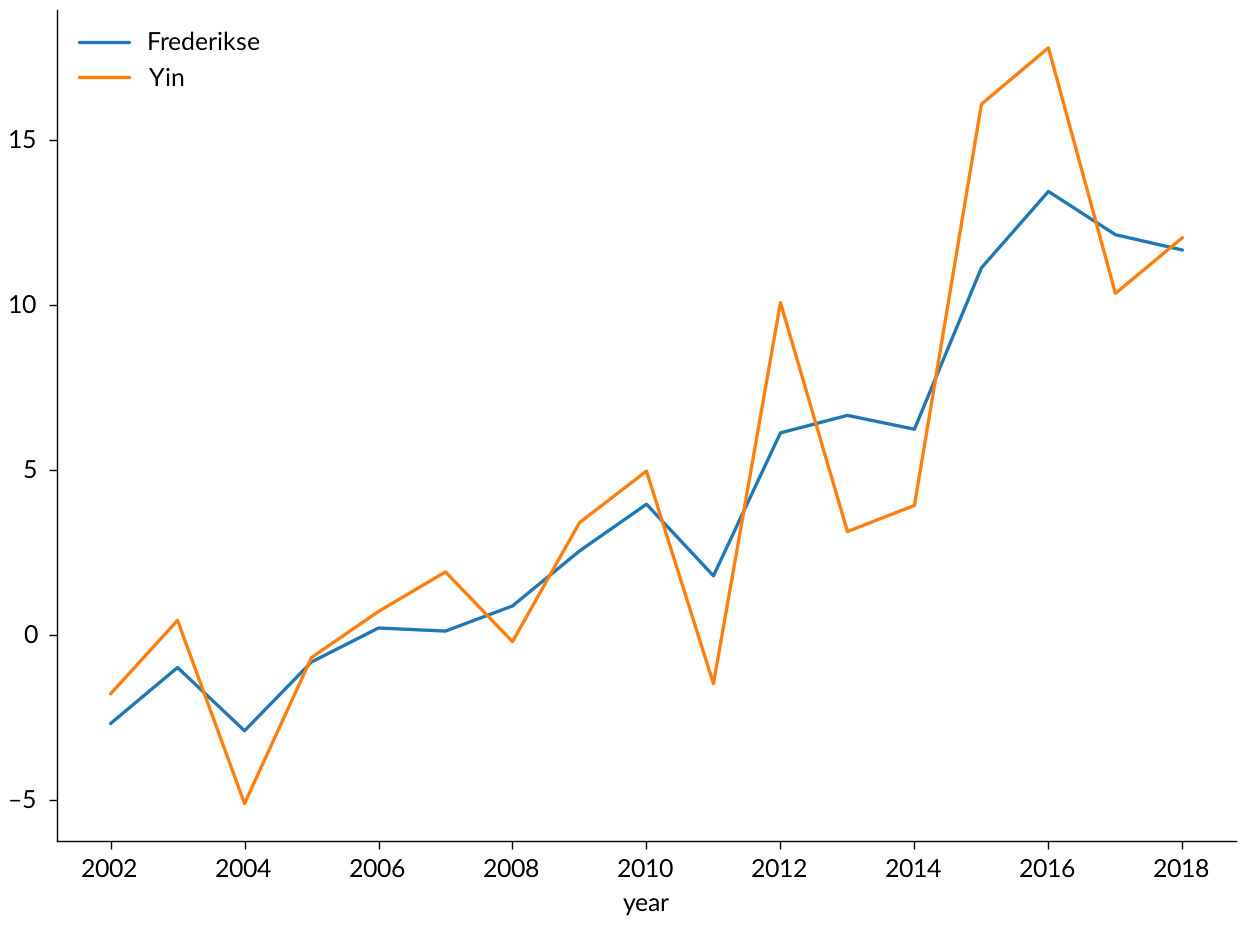

In [19]:
fig, ax = plt.subplots()
tws_fred.loc["2002":"2018"].plot(label="Frederikse")
tws_preds.yin_csr_full.loc["2002":"2018"].plot(label="Yin")
ax.legend();

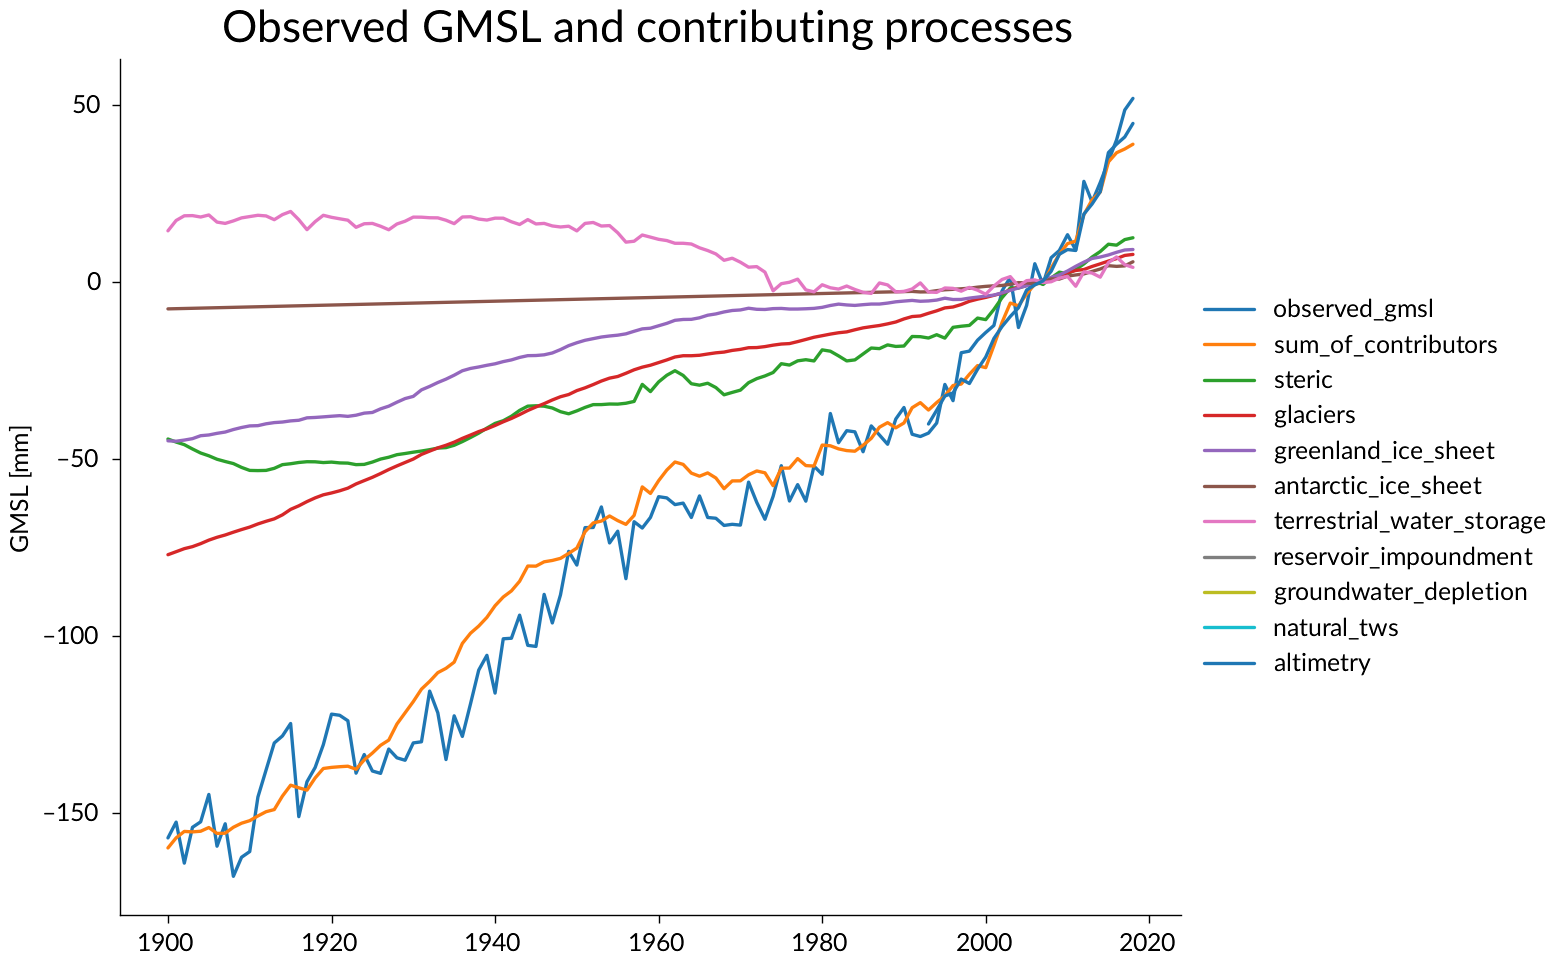

In [20]:
ax = df_mean.plot(figsize=(8, 5))
ax.set_title("Observed GMSL and contributing processes", **title_kwargs)
ax.set_xlabel(None)
ax.set_ylabel("GMSL [mm]")
sns.move_legend(
    ax, loc="center left", bbox_to_anchor=(1, 0.5), title=None, frameon=False
)

## Plot budget closure

In [21]:
# Combined components of the GMSL budget without TWS
gmsl_wo_tws = df_mean.steric + df_mean.greenland_ice_sheet + df_mean.antarctic_ice_sheet

In [22]:
# Default Seaborn color palette, but without gray
cmap = [*sns.color_palette()]
cmap.pop(7);

In [23]:
nvars = len(tws_preds.columns)
ncols = 2
nrows = int(np.ceil(nvars / ncols))

subplot_kwargs = dict(
    nrows=nrows, ncols=ncols, figsize=(5.8, 5), sharex=True, sharey=True
)

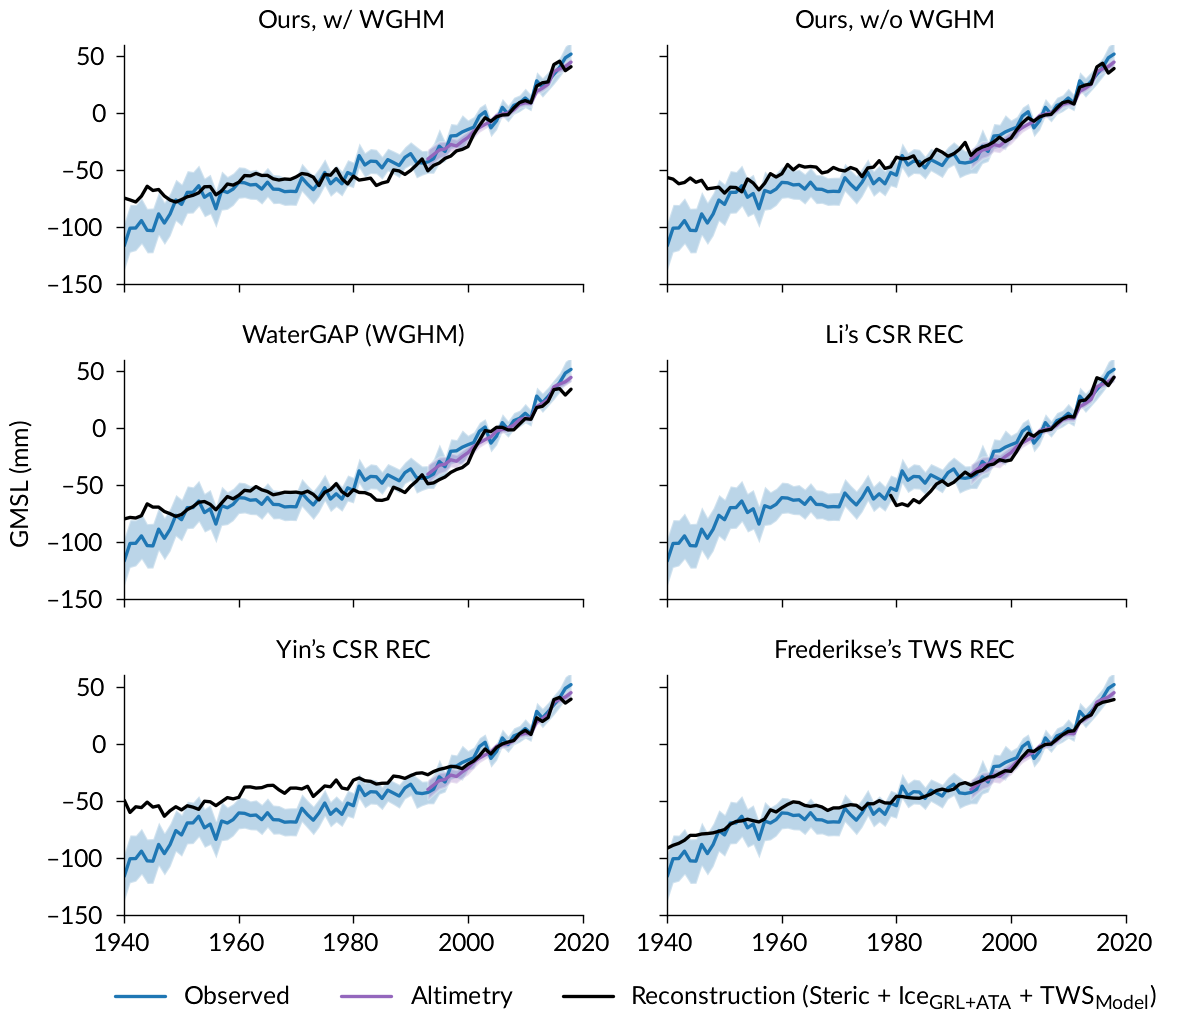

In [31]:
fig, axs = plt.subplots(**subplot_kwargs)

labels_ = [
    "Observed",
    "Altimetry",
    r"Reconstruction (Steric + Ice$_\text{GRL+ATA}$ + TWS$_\text{Model}$)",
]
for i, ax, (name, tws_pred) in zip(range(nvars), axs.flat, tws_preds.items()):
    labels = labels_ if i == 0 else ["_"] * 3
    locator = ticker.MultipleLocator(50)
    # Plot observed
    ax.plot(df_mean.observed_gmsl, label=labels[0], color=cmap[0])
    ax.fill_between(
        df_mean.index,
        y1=df_lower.observed_gmsl,
        y2=df_upper.observed_gmsl,
        alpha=0.3,
        facecolor=cmap[0],
    )

    # Plot altimetry
    ax.plot(df_mean.altimetry, label=labels[1], color=cmap[4])
    ax.fill_between(
        df_mean.index,
        y1=df_lower.altimetry,
        y2=df_upper.altimetry,
        alpha=0.3,
        facecolor=cmap[4],
    )

    # Plot reconstruction
    ax.plot(gmsl_wo_tws + tws_pred, label=labels[2], color="black")

    ax.set_title(vars_verbose[name])
    ax.set_xlim((1940, 2020))
    ax.set_ylim((-150, 60))
    ax.label_outer()
    ax.yaxis.set_major_locator(locator)

fig.legend(
    loc="lower right", bbox_to_anchor=(1.0, -0.05), ncol=3, title=None, frameon=False
)
# Set common labels
fig.text(0.0, 0.5, "GMSL (mm)", ha="center", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "gmsl_observed.pdf", backend="pgf")

Budget closure during Alitmetry era:

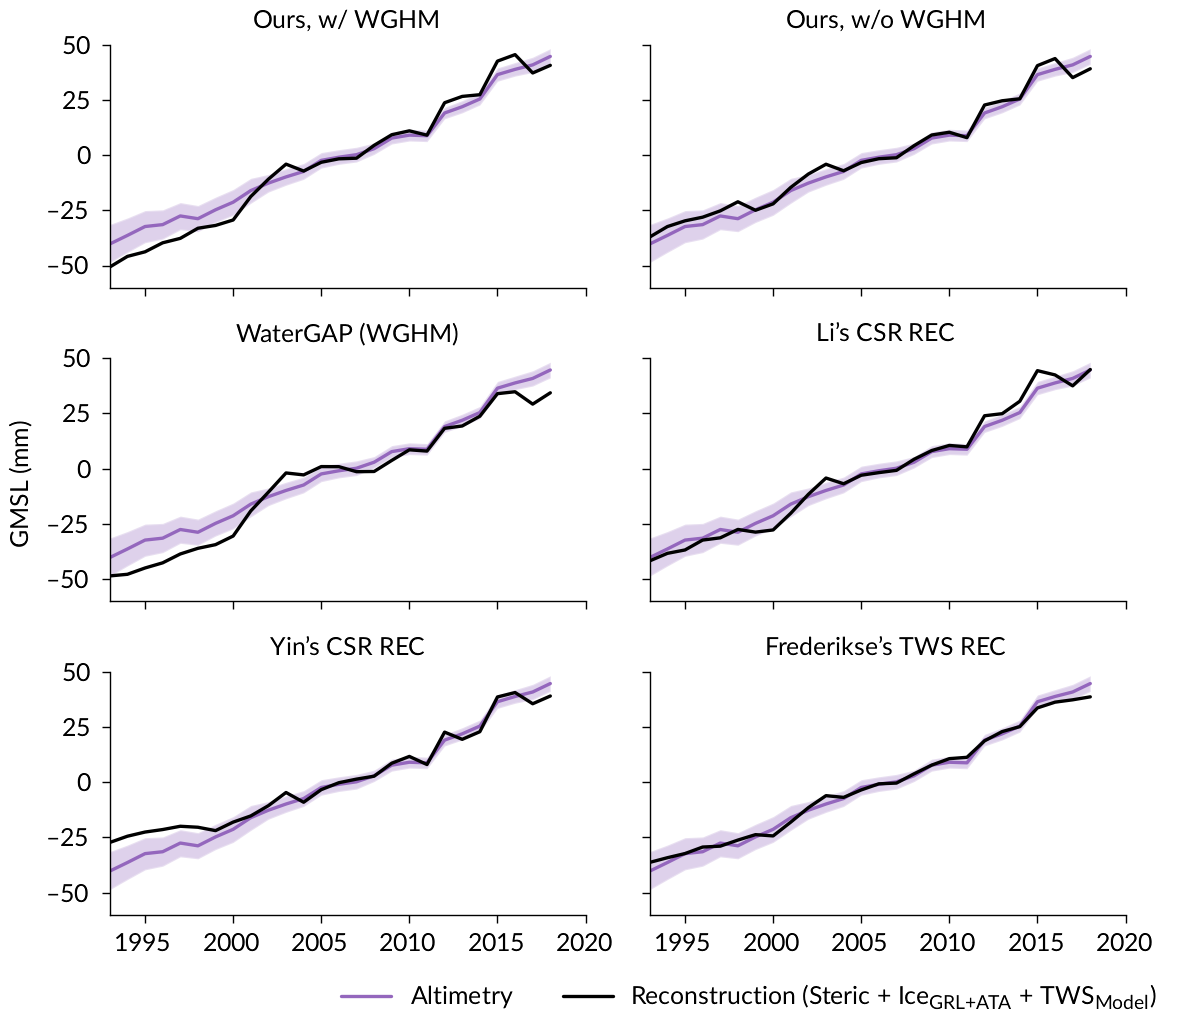

In [37]:
fig, axs = plt.subplots(**subplot_kwargs)

labels_ = [
    "Altimetry",
    r"Reconstruction (Steric + Ice$_\text{GRL+ATA}$ + TWS$_\text{Model}$)",
]
locator = ticker.MultipleLocator(25)
for i, ax, (name, tws_pred) in zip(range(nvars), axs.flat, tws_preds.items()):
    labels = labels_ if i == 0 else ["_"] * 2
    # Plot altimetry
    ax.plot(df_mean.altimetry, label=labels[0], color=cmap[4])
    ax.fill_between(
        df_mean.index,
        y1=df_lower.altimetry,
        y2=df_upper.altimetry,
        alpha=0.3,
        facecolor=cmap[4],
    )

    # Plot reconstruction
    ax.plot(gmsl_wo_tws + tws_pred, label=labels[1], color="black")
    ax.set_title(vars_verbose[name])
    ax.set_xlim((1993, 2020))
    ax.set_ylim((-60, 50))
    ax.label_outer()
    ax.yaxis.set_major_locator(locator)

fig.legend(
    loc="lower right", bbox_to_anchor=(1.0, -0.05), ncol=3, title=None, frameon=False
)
# Set common labels
fig.text(0.0, 0.5, "GMSL (mm)", ha="center", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "gmsl_altimetry.pdf", backend="pgf")

## Decadal closure chart

Calculate the error per model and decade.

In [27]:
start = 1950
end = 2020
SEGMENT_LENGTH = 10  # years
error_list = []

tws_preds_long = tws_preds.stack().rename_axis(["year", "model"])
sum_long = tws_preds_long + gmsl_wo_tws


curr_start = start
# Iterate over all time periods
while (curr_end := curr_start + SEGMENT_LENGTH - 1) <= end:
    # Slice to specified duration
    # Timestamps must be strings, end year is inclusive
    sum_seg = sum_long.loc[str(curr_start) : str(curr_end)]
    obs_seg = df_mean.observed_gmsl.loc[str(curr_start) : str(curr_end)]

    # Remove variables which are NA for most of the time
    years = sum_seg.reset_index().year.unique()
    n_years = len(years)
    models = sum_seg.reset_index().model.unique()
    for model in models:
        if len(sum_seg.loc[:, model].dropna()) < 0.5 * n_years:
            sum_seg = sum_seg.drop(model, level="model")

    # Remove all time steps which are NA for at least one variable
    years_with_na = sum_seg.isna().groupby("year").any()
    years_to_drop = years_with_na[years_with_na].index.tolist()
    sum_seg = sum_seg[~sum_seg.index.get_level_values("year").isin(years_to_drop)]

    # Calculate the MAE
    absolute_error = np.abs(sum_seg - obs_seg)
    mae = (
        absolute_error.reset_index(name="error")
        .groupby("model")
        .mean()
        # Add time period column
        .drop("year", axis=1)
        .assign(time=pd.Timestamp(str(curr_start + SEGMENT_LENGTH // 2)))
    )

    error_list.append(mae)

    # Increase start year
    curr_start += SEGMENT_LENGTH

In [28]:
df_errors = pd.concat(error_list).reset_index()
models = vars_verbose.keys()
df_errors.model = pd.Categorical(df_errors.model, categories=models, ordered=True)

In [29]:
df_errors_verbose = df_errors.copy(deep=True)
df_errors_verbose.model = df_errors_verbose.model.cat.rename_categories(vars_verbose)

In [30]:
# Permute color palette to give RECs the same colors as in grace_metrics.ipynb
cmap = sns.color_palette()
cmap_rearranged = np.array(cmap)[[0, 1, 2, 4, 5, 9]].tolist()

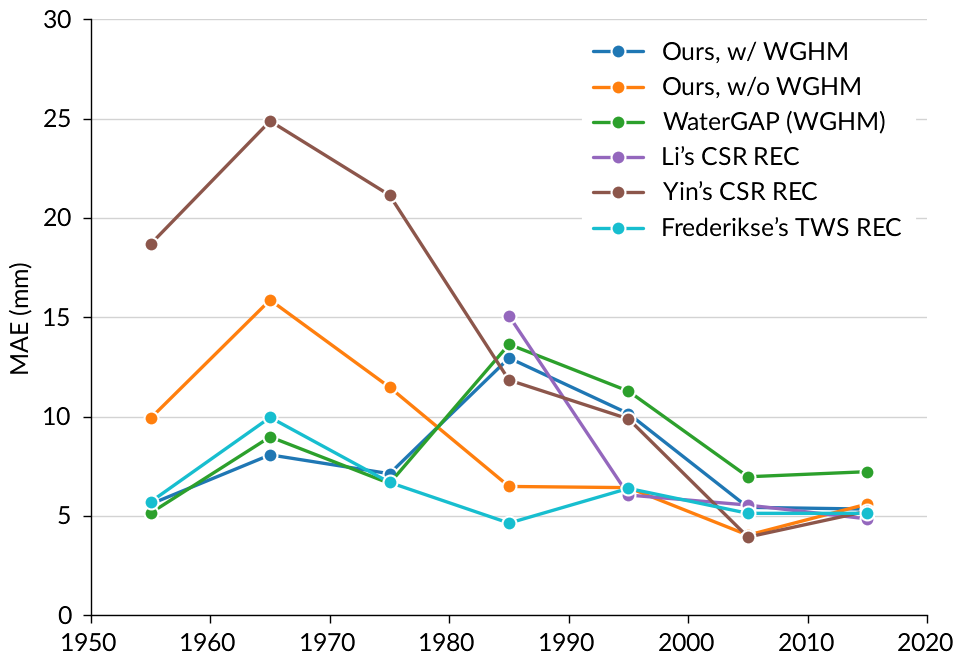

In [31]:
fig, ax = plt.subplots(figsize=(5, 3.5))

sns.lineplot(
    df_errors_verbose,
    x="time",
    y="error",
    hue="model",
    marker="o",
    palette=cmap_rearranged,
    ax=ax,
)
ax.set(
    xlabel=None,
    ylabel="MAE (mm)",
    xlim=(pd.Timestamp(str(start)), pd.Timestamp(str(end))),
    ylim=(0, 30),
)
ax.yaxis.grid(True)

ax.legend(
    loc="upper right",
    frameon=True,
)

In [32]:
import matplotlib.dates as mdates

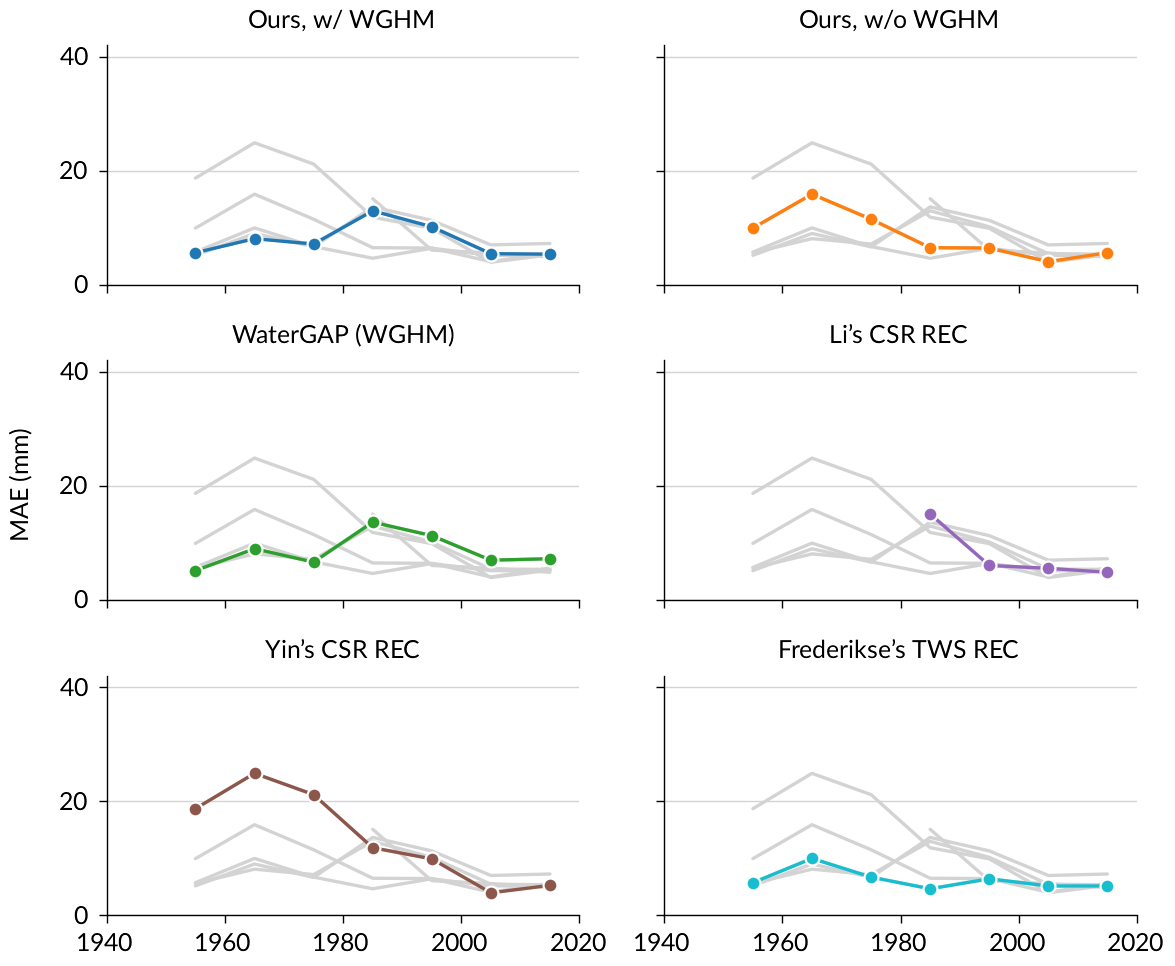

In [33]:
fig, axs = plt.subplots(**subplot_kwargs)

# Iterate over predictions/inputs
for i, (ax, plot_var) in enumerate(zip(axs.flat, models)):
    # Plot background
    for model in models:
        df_plot = df_errors[df_errors.model == model]
        ax.plot(df_plot.time, df_plot.error, color="lightgray")
    # Plot highlight
    df_plot = df_errors[df_errors.model == plot_var]
    ax.plot(
        df_plot.time,
        df_plot.error,
        color=cmap_rearranged[i],
        marker="o",
        markeredgecolor="w",
    )
    ax.set(
        title=vars_verbose[plot_var],
        xlim=(pd.Timestamp("1940"), pd.Timestamp("2020")),
        ylim=(0, 42),
    )
    ax.xaxis.set_major_locator(mdates.YearLocator(base=20))
    ax.label_outer()
    ax.yaxis.grid(True)
# fig.autofmt_xdate(ha="center")
# Set common labels
fig.text(0, 0.5, "MAE (mm)", ha="right", va="center", rotation="vertical")

In [148]:
df_errors = np.abs(sum_long - df_mean.observed_gmsl)
df_errors = df_errors.rename("error")  # .reset_index()
df_roll = (
    df_errors.groupby(level="model", group_keys=False)
    .rolling(3, center=True)
    .mean()
    .droplevel(2)
    .reset_index()
)
df_errors = df_errors.reset_index()

In [151]:
df_errors = df_roll

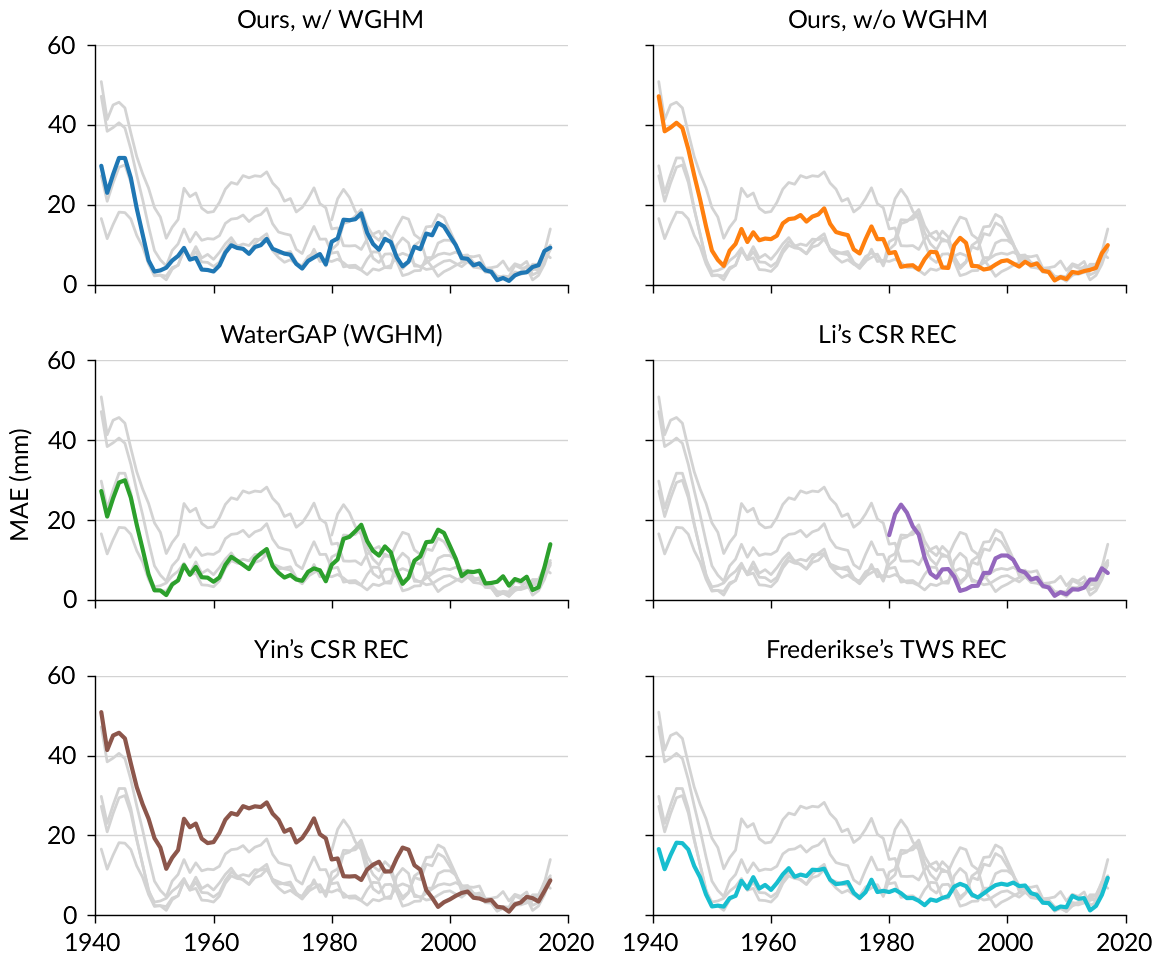

In [166]:
fig, axs = plt.subplots(**subplot_kwargs)

# Iterate over predictions/inputs
for i, (ax, plot_var) in enumerate(zip(axs.flat, models)):
    # Plot background
    for model in models:
        df_plot = df_errors[df_errors.model == model]
        ax.plot(df_plot.year, df_plot.error, color="lightgray", linewidth=1.0)
    # Plot highlight
    df_plot = df_errors[df_errors.model == plot_var]
    ax.plot(df_plot.year, df_plot.error, color=cmap_rearranged[i], linewidth=1.5)
    ax.set(
        title=vars_verbose[plot_var],
        xlim=(1940, 2020),
        ylim=(0, 60),
    )
    ax.label_outer()
    ax.yaxis.grid(True)
# Set common labels
fig.text(0, 0.5, "MAE (mm)", ha="center", va="center", rotation="vertical")
fig.savefig(FIGURE_DIR / "gmsl_closure.pdf", backend="pgf")

## Plot Estimated vs. Predicted TWS

In [34]:
# Calculated the estimated TWS (Observation - est. ice - est. steric) and its variance
obs_tws = (
    df_mean.observed_gmsl
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)
var_obs_tws = (
    variances.observed_gmsl
    - variances.steric
    - variances.greenland_ice_sheet
    - variances.antarctic_ice_sheet
)
error_obs_tws = Z_SCORE * np.sqrt(var_obs_tws)
ubound_obs_tws = obs_tws + error_obs_tws
lbound_obs_tws = obs_tws - error_obs_tws

# Calculated the estimated TWS (Altimetry - est. ice - est. steric) and its variance
alt_tws = (
    df_mean.altimetry
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)
var_alt_tws = (
    variances.altimetry
    - variances.steric
    - variances.greenland_ice_sheet
    - variances.antarctic_ice_sheet
)
error_alt_tws = Z_SCORE * np.sqrt(var_alt_tws)
ubound_alt_tws = alt_tws + error_alt_tws
lbound_alt_tws = alt_tws - error_alt_tws

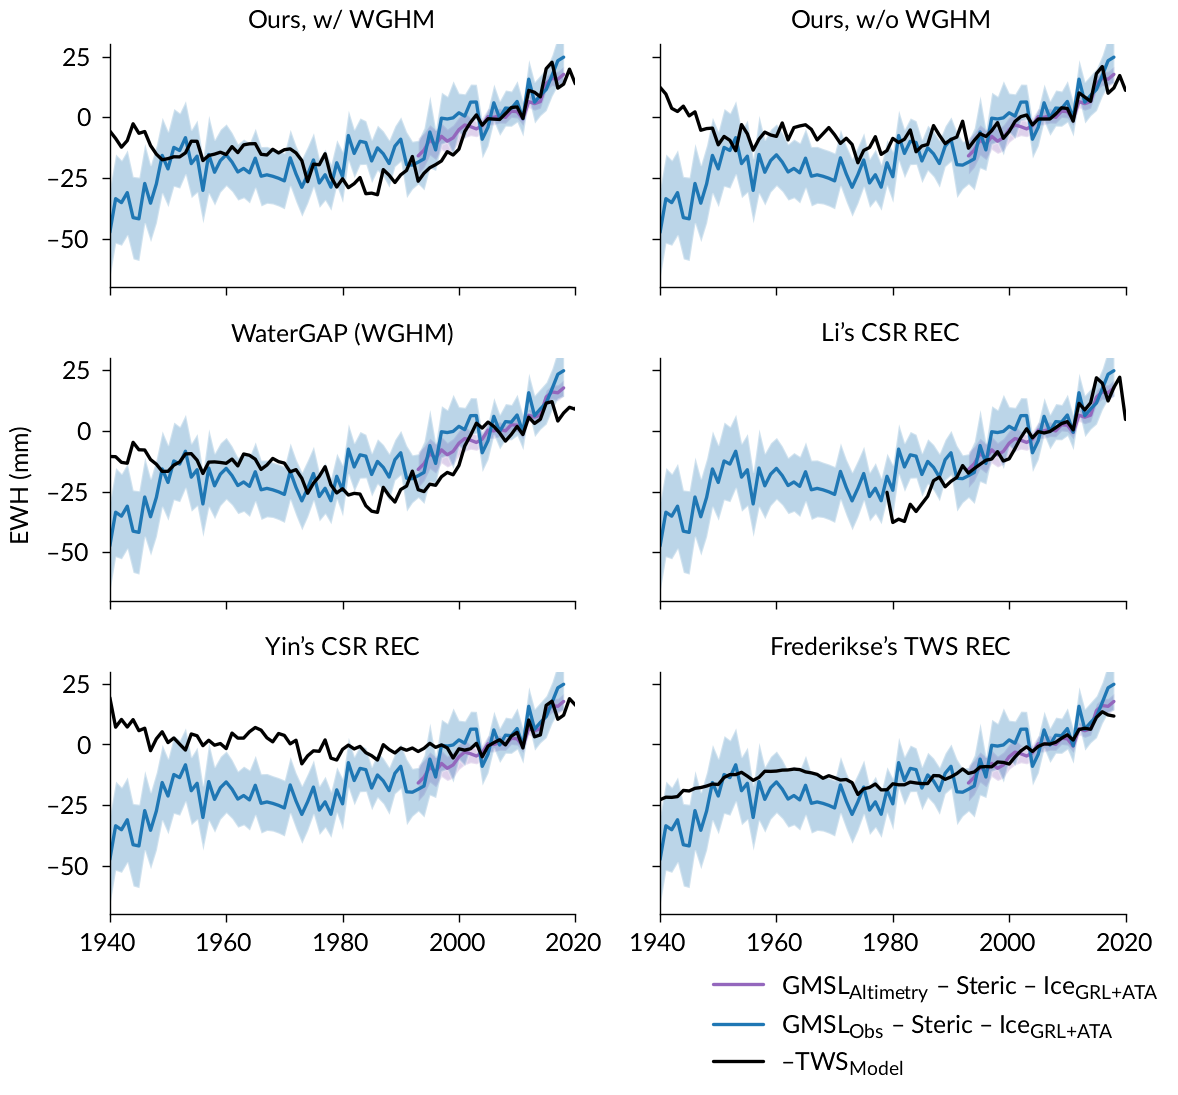

In [35]:
fig, axs = plt.subplots(**subplot_kwargs)

for i, ax, (name, tws_pred) in zip(range(nvars), axs.flat, tws_preds.items()):
    labels = (
        [
            r"$\text{GMSL}_\text{Altimetry}-\text{Steric}-\text{Ice}_\text{GRL+ATA}$",
            r"$\text{GMSL}_\text{Obs}-\text{Steric}-\text{Ice}_\text{GRL+ATA}$",
            r"$-\text{TWS}_\text{Model}$",
        ]
        if i == 0
        else ["_"] * 3
    )
    # Plot  altimetry
    ax.plot(alt_tws, label=labels[0], color=cmap[4])
    ax.fill_between(
        alt_tws.index,
        y1=ubound_alt_tws,
        y2=lbound_alt_tws,
        alpha=0.3,
        facecolor=cmap[4],
    )
    # Plot estimate from pbserved
    ax.plot(obs_tws, label=labels[1], color=cmap[0])
    ax.fill_between(
        obs_tws.index,
        y1=ubound_obs_tws,
        y2=lbound_obs_tws,
        alpha=0.3,
        facecolor=cmap[0],
    )

    # Plot reconstruction
    ax.plot(tws_pred, label=labels[2], color="black")
    ax.set_title(vars_verbose[name])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.label_outer()
    ax.set_xlim((1940, 2020))
    ax.set_ylim((-70, 30))
    ax.label_outer()

fig.legend(loc="upper right", bbox_to_anchor=(1.0, 0.03), title=None)
# Set common labels
fig.text(0.0, 0.5, "EWH (mm)", ha="center", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "gmsl_tws_observed.pdf", backend="pgf")

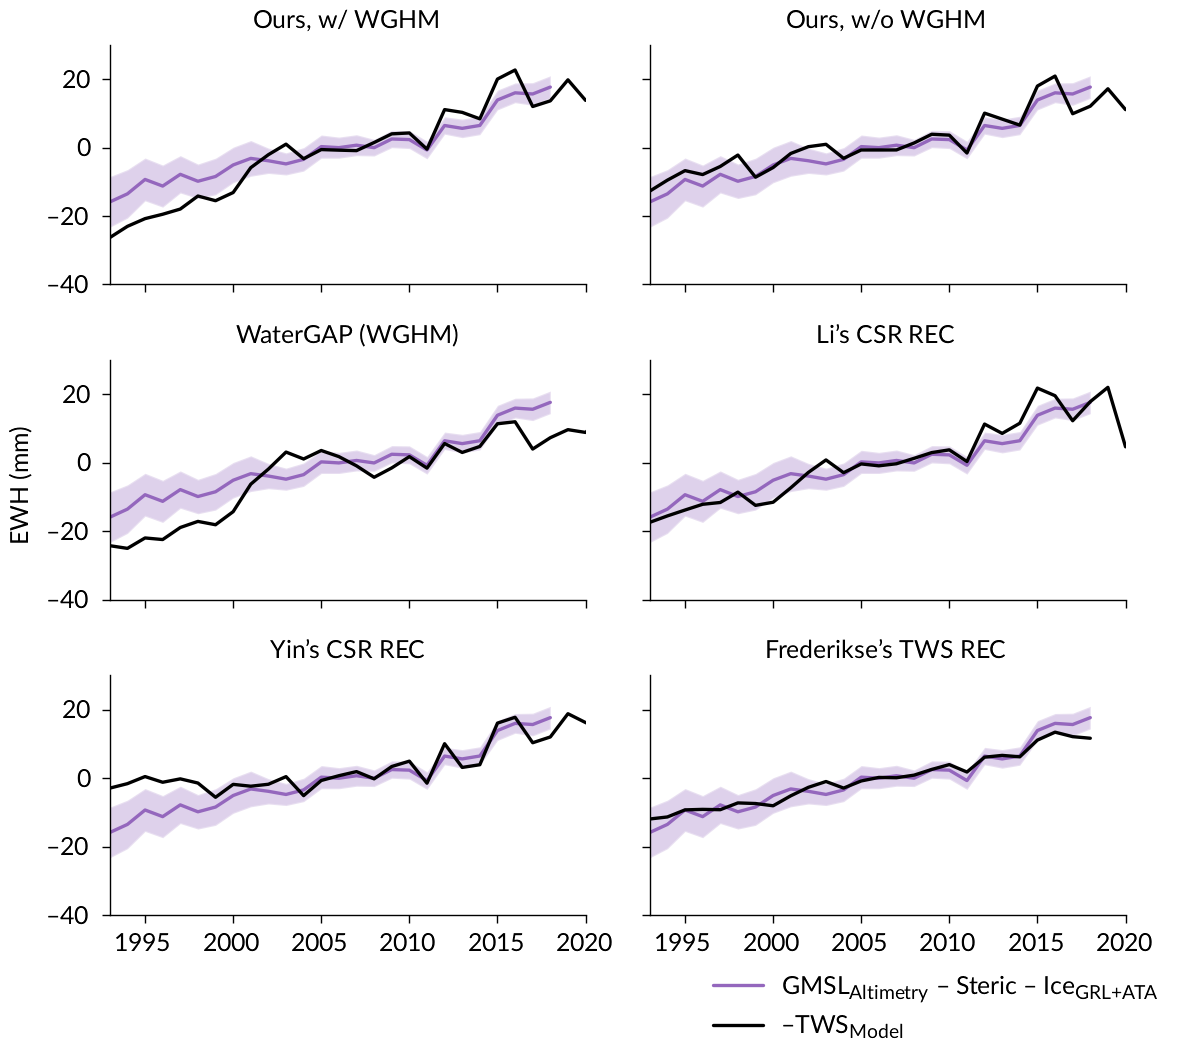

In [36]:
fig, axs = plt.subplots(**subplot_kwargs)

for i, ax, (name, tws_pred) in zip(range(nvars), axs.flat, tws_preds.items()):
    labels = (
        [
            r"$\text{GMSL}_\text{Altimetry}-\text{Steric}-\text{Ice}_\text{GRL+ATA}$",
            r"$-\text{TWS}_\text{Model}$",
        ]
        if i == 0
        else ["_"] * 3
    )
    # Plot altimetry
    ax.plot(alt_tws, label=labels[0], color=cmap[4])
    ax.fill_between(
        alt_tws.index,
        y1=ubound_alt_tws,
        y2=lbound_alt_tws,
        alpha=0.3,
        facecolor=cmap[4],
    )

    # Plot reconstruction
    ax.plot(tws_pred, label=labels[1], color="black")
    ax.set_title(vars_verbose[name])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.label_outer()
    ax.set_xlim((1993, 2020))
    ax.set_ylim((-40, 30))

fig.legend(loc="upper right", bbox_to_anchor=(1.0, 0.03), title=None)
# Set common labels
fig.text(0.0, 0.5, "EWH (mm)", ha="center", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "gmsl_tws_altimetry.pdf", backend="pgf")

### Degree of budget closure

In [37]:
start = 1940
end = 2020
SEGMENT_LENGTH = 10  # years
error_list = []

tws_preds_long = tws_preds.stack().rename_axis(["year", "model"])

curr_start = start
# Iterate over all time periods
while (curr_end := curr_start + SEGMENT_LENGTH - 1) <= end:
    # Slice to specified duration
    # Timestamps must be strings, end year is inclusive
    rec_seg = tws_preds_long.loc[str(curr_start) : str(curr_end)]
    obs_seg = obs_tws.loc[str(curr_start) : str(curr_end)]

    # Remove variables which are NA for most of the time
    years = rec_seg.reset_index().year.unique()
    n_years = len(years)
    models = rec_seg.reset_index().model.unique()
    for model in models:
        if len(rec_seg.loc[:, model].dropna()) < 0.5 * n_years:
            rec_seg = rec_seg.drop(model, level="model")

    # Remove all time steps which are NA for at least one variable
    years_with_na = rec_seg.isna().groupby("year").any()
    years_to_drop = years_with_na[years_with_na].index.tolist()
    rec_seg = rec_seg[~rec_seg.index.get_level_values("year").isin(years_to_drop)]

    # Calculate the MAE
    absolute_error = np.abs(rec_seg - obs_seg)
    mae = (
        absolute_error.reset_index(name="error")
        .groupby("model")
        .mean()
        # Add time period column
        .drop("year", axis=1)
        .assign(time=pd.Timestamp(str(curr_start + SEGMENT_LENGTH // 2)))
    )

    error_list.append(mae)

    # Increase start year
    curr_start += SEGMENT_LENGTH

In [38]:
df_errors = pd.concat(error_list).reset_index()
models = vars_verbose.keys()
df_errors.model = pd.Categorical(df_errors.model, categories=models, ordered=True)

In [39]:
# Permute color palette to give RECs the same colors as in grace_metrics.ipynb
cmap_rearranged = np.array(cmap)[[0, 1, 2, 4, 5, 8]]

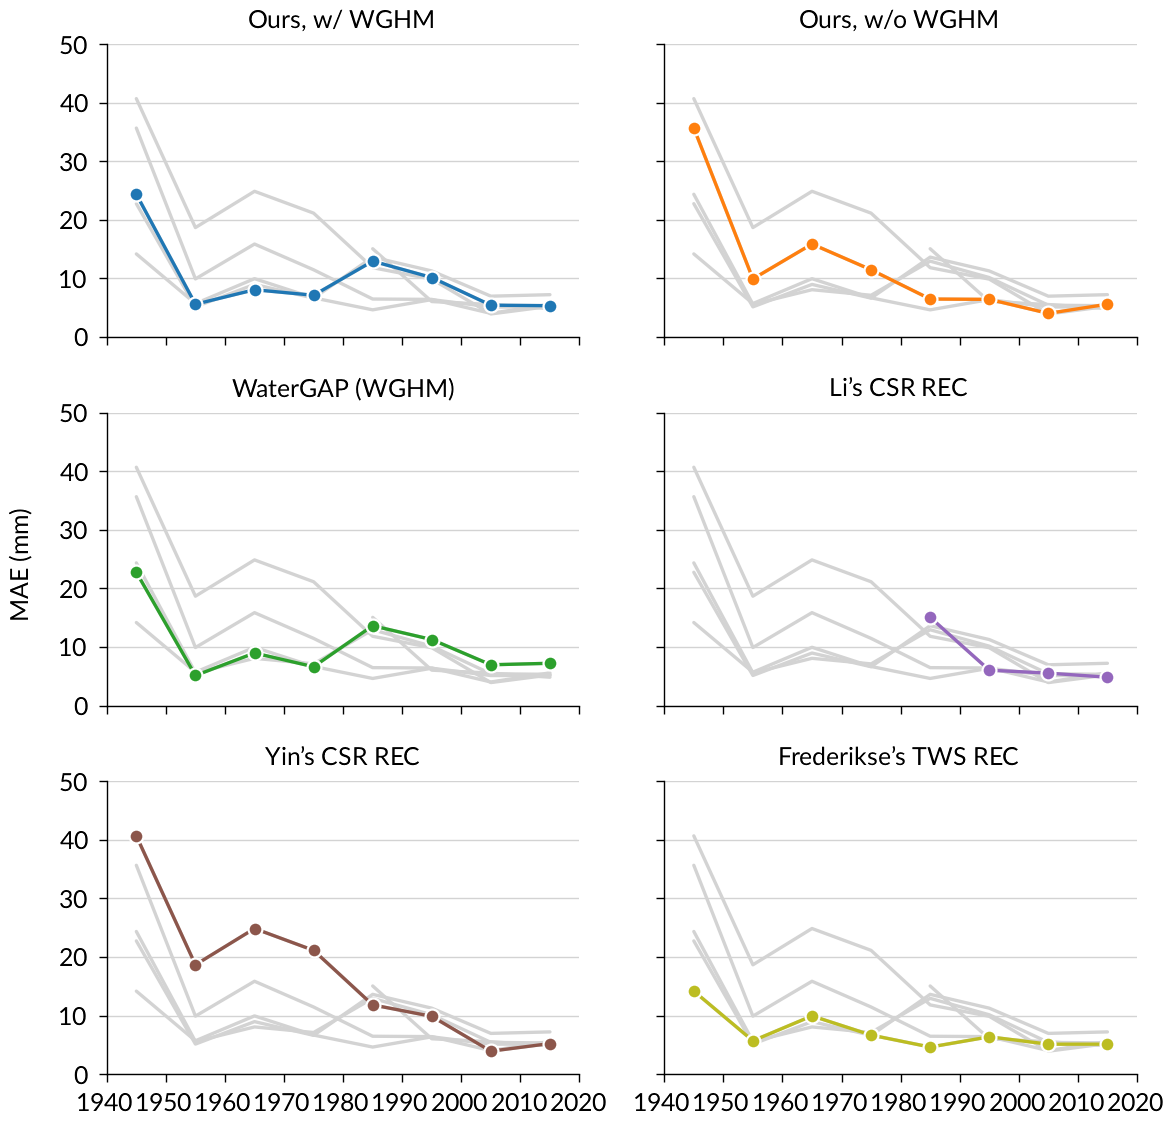

In [40]:
subplot_kwargs["figsize"] = (5.8, 5.8)

fig, axs = plt.subplots(**subplot_kwargs)

# Iterate over predictions/inputs
for i, (ax, plot_var) in enumerate(zip(axs.flat, models)):
    # Plot background
    for model in models:
        df_plot = df_errors[df_errors.model == model]
        ax.plot(df_plot.time, df_plot.error, color="lightgray")
    # Plot highlight
    df_plot = df_errors[df_errors.model == plot_var]
    ax.plot(
        df_plot.time,
        df_plot.error,
        color=cmap_rearranged[i],
        marker="o",
        markeredgecolor="w",
    )
    ax.set(
        title=vars_verbose[plot_var],
        xlim=(pd.Timestamp("1940"), pd.Timestamp("2020")),
        ylim=(0, 50),
    )
    ax.label_outer()
    ax.yaxis.grid(True)

# Set common labels
fig.text(0, 0.5, "MAE (mm)", ha="right", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "gmsl_tws_closure.pdf", backend="pgf")